# Random Forest Regression Model Training
Testing the training of a combined St Ebbes & High St RF model.

## Import external modules

In [1]:
# Python library imports
# ------------------------
import datetime as dt
import pickle

%matplotlib inline
import sys
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import csv
import numpy as np
import pandas as pd
import pytz
import seaborn as sns
import sklearn
from matplotlib.dates import DateFormatter, MonthLocator
from matplotlib.ticker import FuncFormatter
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline

pd.plotting.register_matplotlib_converters()
# pd.set_option('display.max_colwidth', -1)

# File locations
# ----------------
data_home = './oxaria/processed/'
rf_home = './oxaria/processed/models/lockdown_paper/'
pngs = './oxaria/pngs/'


## Define local functions
Declare some functions for use later & reduce code repetition.

In [2]:
# Sensor data for colocated device at St Ebbes
# ----------------------------------------------
def load_pm104_training(folder,ftr_list, combo_cols):
    df_list = []
    tuple_list = zip(ftr_list, combo_cols)
    for f, c in tuple_list:
        # read the feather files
        dftmp = (
            pd.read_feather(folder + f)
            .set_index(['tag','rec'])
            .sort_index()
        )
        # Convert all float64 cols to float32
        cols = dftmp.select_dtypes(np.float64).columns
        dftmp[cols] = dftmp[cols].astype(np.float32)
        # Combine the reference method conc column into 1 column
        dftmp['pm10_ugg_combo'] = dftmp[c]
        # If its below 3 ug.m-3, its probably not, so set to nan
        dftmp['pm10_ugg_combo'] = np.where(
            dftmp['pm10_ugg_combo'] < 3.0, np.nan, dftmp['pm10_ugg_combo'])
        df_list.append(dftmp)    
    df_out = pd.concat(df_list)
    df_out = df_out[~df_out.index.duplicated(keep='last')]

    return df_out   

# Sensor data for colocated device at St Ebbes
# ----------------------------------------------
def load_pm254_training(folder,ftr_list, combo_cols):
    df_list = []
    tuple_list = zip(ftr_list, combo_cols)
    for f, c in tuple_list:
        # read the feather files
        dftmp = (
            pd.read_feather(folder + f)
            .set_index(['tag','rec'])
            .sort_index()
        )
        # Convert all float64 cols to float32
        cols = dftmp.select_dtypes(np.float64).columns
        dftmp[cols] = dftmp[cols].astype(np.float32)
        df_list.append(dftmp)    
    df_out = pd.concat(df_list)
    df_out = df_out[~df_out.index.duplicated(keep='last')]
    return df_out 

# Function to generate time lagged feature
# -----------------------------------------
def no2_feature_gen(df):
    # calc % change in all df cols over last 15 mins
    tmpdf1 = (
        df.apply(lambda x: pd.to_numeric(x, errors='coerce'))
        .dropna(axis=1, how='all')
        .pct_change(periods=1)
    )
    tmpdf1.columns = ['pc15_' + name for name in list(tmpdf1.columns)]
    # and same over last 30 mins
    tmpdf2 = (
        df.apply(lambda x: pd.to_numeric(x, errors='coerce'))
        .dropna(axis=1, how='all')
        .pct_change(periods=2)
    )
    tmpdf2.columns = ['pc30_' + name for name in list(tmpdf2.columns)]
    # merge % change stats back on to original df
    df = (
        df.merge(tmpdf1, left_index=True, right_index=True, how='left')
        .merge(tmpdf2, left_index=True, right_index=True, how='left')
        .set_index(['tag', 'rec'])
    )
    return df

# Function to generate rush hour & temporal flag features
# --------------------------------------------------------
def rushhour(df):
    # calc integer flags for hour of observation
    df['hour'] = df.index.get_level_values(1).hour
    # and day of week
    df['day'] = df.index.get_level_values(1).dayofweek
    # and integer flag(s) for off-peak, morning & evening rush hours
    df.loc[
        (df.index.get_level_values(1).time >= dt.time(7, 30, 0))
        & (df.index.get_level_values(1).time >= dt.time(9, 30, 0))
        & (df.index.get_level_values(1).weekday < 5),
        'rushhour',
    ] = 1
    df.loc[
        (df.index.get_level_values(1).time >= dt.time(16, 0, 0))
        & (df.index.get_level_values(1).time >= dt.time(18, 0, 0))
        & (df.index.get_level_values(1).weekday < 5),
        'rushhour',
    ] = 2
    df['rushhour'] = np.where(df['rushhour'] >= 1, df['rushhour'], 0).astype(np.int32)
    return df

# Function to constrain get training features for a soecific date envelope
#--------------------------------------------------------------------------
def get_training_pm10(dfs, env_start, env_stop):
    start = pd.to_datetime(env_start, infer_datetime_format=True, utc=True)
    end = pd.to_datetime(env_stop, infer_datetime_format=True, utc=True)
    
    print('Getting training features for sensors between: '+str(start)+' and '+str(end)+'\n')
    df_list = []
    
    for df in dfs:
        dftmp = df.query('@start <= rec < @end').reset_index().set_index(['tag','rec'])
        df_list.append(dftmp)
    
    df_out = pd.concat(df_list).sort_index()
    df_out = df_out[~df_out.index.duplicated(keep='last')]
    df_out = df_out.loc[
        :,
        [
            'val.mtf1',
            'val.mtf5',
            'val.mtf3',
            'val.mtf7',
            'val.sfr',
            'val.hmd',
            'val.tmp',
            'pc15_val.mtf1',
            'pc15_val.mtf5',
            'pc15_val.mtf3',
            'pc15_val.mtf7',
            'pc15_val.sfr',
            'pc15_val.hmd',
            'pc15_val.tmp',
            'pc30_val.mtf1',
            'pc30_val.mtf5',
            'pc30_val.mtf3',
            'pc30_val.mtf7',
            'pc30_val.sfr',
            'pc30_val.hmd',
            'pc30_val.tmp',
            'hour',
            'day',
            'pm10_ugg_s',
            'pm25_ugg_s',
            'pm10_ugg_h',
            'pm10_ugg_combo',
            'val.pm10_1_c1',
            'pc15_val.pm10_1_c1',
            'pc30_val.pm10_1_c1',
        ],
    ]
    df_out = df_out.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
    print('Sensors in output :'+str(df_out.index.get_level_values(0).unique().tolist())+'\n')
    return df_out

# Function to constrain get training features for a soecific date envelope
#--------------------------------------------------------------------------
def get_training_pm25(dfs, env_start, env_stop):
    start = pd.to_datetime(env_start, infer_datetime_format=True, utc=True)
    end = pd.to_datetime(env_stop, infer_datetime_format=True, utc=True)
    
    print('Getting training features for sensors between: '+str(start)+' and '+str(end)+'\n')
    df_list = []
    
    for df in dfs:
        dftmp = df.query('@start <= rec < @end').reset_index().set_index(['tag','rec'])
        df_list.append(dftmp)
    
    df_out = pd.concat(df_list).sort_index()
    df_out = df_out[~df_out.index.duplicated(keep='last')]
    df_out = df_out.loc[
        :,
        [
            'val.mtf1',
            'val.mtf5',
            'val.mtf3',
            'val.mtf7',
            'val.sfr',
            'val.hmd',
            'val.tmp',
            'pc15_val.mtf1',
            'pc15_val.mtf5',
            'pc15_val.mtf3',
            'pc15_val.mtf7',
            'pc15_val.sfr',
            'pc15_val.hmd',
            'pc15_val.tmp',
            'pc30_val.mtf1',
            'pc30_val.mtf5',
            'pc30_val.mtf3',
            'pc30_val.mtf7',
            'pc30_val.sfr',
            'pc30_val.hmd',
            'pc30_val.tmp',
            'hour',
            'day',
            'pm25_ugg_s',
            'val.pm2p5_1_c1',
            'pc15_val.pm2p5_1_c1',
            'pc30_val.pm2p5_1_c1',
        ],
    ]
    df_out = df_out.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
    print('Sensors in output :'+str(df_out.index.get_level_values(0).unique().tolist())+'\n')
    return df_out

# Define a function to test model performance based on a range of max. no, of leaf node sizes
# ---------------------------------------------------------------------------------------------
# The following function estimates mean absolute error as a metric for model
# accuracy.The number of trees used is set to 100 (i.e. n_estimators). 500 trees have also been tested but
# without any imporvement in accuracy so 100 is used to reduce training times.
def get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):

    # Define the model
    model = RandomForestRegressor(
        max_leaf_nodes=max_leaf_nodes, random_state=7, n_estimators=100, n_jobs=-1
    )

    # Create a v simple pipeline that imputes missing input values before fitting the model to them
    # -----------------------------------------------------------------------------------------------
    my_pipeline = Pipeline(steps=[('preprocessor', SimpleImputer()), ('model', model)])

    # Calculate a metric variable using the cross_val_score function
    # ----------------------------------------------------------------
    # The block below performs a cross validation excersise. For a given model configuration, it splits the
    # training set in 5 subsets and carries out a training sequence with the mean absolute error as a metric
    # of performance.
    # An avergae of those 5 MAE is then returned (see Figure below 'Validation' label).
    # This procedure ensures a robust training sequence as it removes the chance of
    # selecting a validation set that is very similar to the testing subset.
    #
    # Fit 5 random subsets of train_x & train_y to the pipeline RFR model & calc mean absolute error
    # multiply by -1 since sklearn calculates *negative* MAE
    metric = -1 * cross_val_score(
        my_pipeline, train_X, train_y, cv=5, scoring='neg_mean_absolute_error'
    )

    # Train the model
    my_pipeline.fit(train_X, train_y)

    # Predict dependent variable using validation & training subsets of independent variables
    preds_val = my_pipeline.predict(val_X)
    preds_tr = my_pipeline.predict(train_X)

    # MAE calculation for training and validation data
    mae_ver = mean_absolute_error(val_y, preds_val)
    mae_tr = mean_absolute_error(train_y, preds_tr)

    # Bring it all together in outputs
    return (mae_ver, mae_tr, metric.mean())


# Function to plot a storyboard of model validation
# --------------------------------------------------
def plot_training_story_board_pm10(df, title, save_it, *args):
    sns.set_style('white', {'axes.grid': False})
    fig, axes = plt.subplots(1, 3, figsize=(15, 4.3))
    fig.suptitle(
        title,
        y=1.1,
        fontsize=14,
    )
    plt.rcParams['ytick.labelsize'] = '12'
    plt.rcParams['xtick.labelsize'] = '12'
    plt.rcParams['figure.titlesize'] = '12'

    xlim = [0, 80]
    axes[0].set_xlim(xlim)

    # Get regression stats - sensor vs reference method
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        train_df['val.pm10_1_c1'], train_df['pm10_ugg_combo']
    )
    # Plot it
    sns.regplot(
        x=train_df['pm10_ugg_combo'],
        y=train_df['val.pm10_1_c1'],
        color='tab:blue',
        line_kws={
            'label': 'y = {0:.3f}x+{1:.2f},  R-sqd = {3:.2f}'.format(
                slope, intercept, r_value, r_value ** 2
            )
        },
        ax=axes[0],
        truncate=False,
    )
    axes[0].set(
        xlabel='AURN PM10 (ugm-3)',
        ylabel='Sensor PM10 (ugm-3)',
        title='Uncorrected sensor vs Reference method\n (all observations)',
        xlim=(-100, 3000),
        ylim=(-100, 3000),
        xticks=(np.arange(0, 3200, 400)),
        yticks=(np.arange(0, 3200, 400)),
    )

    one = [0, 100, 3000]
    sns.regplot(
        x=one,
        y=one,
        color='k',
        line_kws={'label': '1:1', 'ls': ':', 'lw': 1},
        scatter_kws={'s': 0},
        ax=axes[0],
        ci=None,
    )

    axes[1].set_xlim(xlim)

    # Recalc regression stats - uncorrected validation subset sensor vs reference method
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        val_y, val_X['val.pm10_1_c1']
    )
    # Plot it
    sns.regplot(
        x=val_y,
        y=val_X['val.pm10_1_c1'],
        color='tab:orange',
        line_kws={
            'label': 'y = {0:.2f}x+{1:.2f},  R-sqd = {3:.2f}'.format(
                slope, intercept, r_value, r_value ** 2
            )
        },
        ax=axes[1],
        truncate=False,
    )
    axes[1].set(
        xlabel='Reference method PM10 (ugm-3)',
        ylabel='Sensor PM10 (ugm-3)',
        title='Uncorrected sensor vs Reference method\n (validation subset)',
        xlim=(-100, 3000),
        ylim=(-100, 3000),
        xticks=(np.arange(0, 3200, 400)),
        yticks=(np.arange(0, 3200, 400)),
    )

    one = [0, 100, 3000]
    sns.regplot(
        x=one,
        y=one,
        color='k',
        line_kws={'label': '1:1', 'ls': ':', 'lw': 1},
        scatter_kws={'s': 0},
        ax=axes[1],
        ci=None,
    )

    axes[2].set_xlim(0, 100)

    # # Recalc regression stats - corrected validation subset sensor vs reference method
    slope, intercept, r_value, p_value, std_err = stats.linregress(val_y, model_prediction)
    sns.regplot(
        x=val_y,
        y=model_prediction,
        color='tab:green',
        line_kws={
            'label': 'y = {0:.2f}x+{1:.2f},  R-sqd = {3:.2f}'.format(
                slope, intercept, r_value, r_value ** 2
            )
        },
        ax=axes[2],
        truncate=False,
    )
    axes[2].set(
        xlabel='Reference method PM10 (ugm-3)',
        ylabel='Corrected Sensor PM10 (ugm-3)',
        title='Corrected sensor vs Reference method\n (validation subset)',
        xlim=(-2, 100),
        ylim=(-2, 100),
        xticks=(np.arange(0, 110, 20)),
        yticks=(np.arange(0, 110, 20)),
    )

    one = [0, 10, 100]
    sns.regplot(
        x=one,
        y=one,
        color='k',
        line_kws={'label': '1:1', 'ls': ':', 'lw': 1},
        scatter_kws={'s': 0},
        ax=axes[2],
        ci=None,
    )

    axes[0].legend(loc='upper center', fontsize=11)
    axes[1].legend(loc='upper center', fontsize=11)
    axes[2].legend(loc='upper center', fontsize=11)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.subplots_adjust(wspace=0.3)

    if save_it == True:
        plt.savefig(f'training_storyboard_pm10_mln{str(model.max_leaf_nodes)}_e{str(model.n_estimators)}_{png_descriptor}.png', dpi=300)
    plt.show()
    return

# Function to plot a storyboard of model validation
# --------------------------------------------------
def plot_training_story_board_pm25(df, title, save_it, *args):
    sns.set_style('white', {'axes.grid': False})
    fig, axes = plt.subplots(1, 3, figsize=(15, 4.3))
    fig.suptitle(
        title,
        y=1.1,
        fontsize=14,
    )
    plt.rcParams['ytick.labelsize'] = '12'
    plt.rcParams['xtick.labelsize'] = '12'
    plt.rcParams['figure.titlesize'] = '12'

    xlim = [0, 80]
    axes[0].set_xlim(xlim)

    # Get regression stats - sensor vs reference method
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        train_df['val.pm2p5_1_c1'], train_df['pm25_ugg_s']
    )
    # Plot it
    sns.regplot(
        x=train_df['pm25_ugg_s'],
        y=train_df['val.pm2p5_1_c1'],
        color='tab:blue',
        line_kws={
            'label': 'y = {0:.3f}x+{1:.2f},  R-sqd = {3:.2f}'.format(
                slope, intercept, r_value, r_value ** 2
            )
        },
        ax=axes[0],
        truncate=False,
    )
    axes[0].set(
        xlabel='AURN PM2.5 (ugm-3)',
        ylabel='Sensor PM2.5 (ugm-3)',
        title='Uncorrected sensor vs Reference method\n (all observations)',
        xlim=(-20, 600),
        ylim=(-20, 600),
        xticks=(np.arange(0, 620, 100)),
        yticks=(np.arange(0, 620, 100)),
    )

    one = [0, 100, 720]
    sns.regplot(
        x=one,
        y=one,
        color='k',
        line_kws={'label': '1:1', 'ls': ':', 'lw': 1},
        scatter_kws={'s': 0},
        ax=axes[0],
        ci=None,
    )

    axes[1].set_xlim(xlim)

    # Recalc regression stats - uncorrected validation subset sensor vs reference method
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        val_y, val_X['val.pm2p5_1_c1']
    )
    # Plot it
    sns.regplot(
        x=val_y,
        y=val_X['val.pm2p5_1_c1'],
        color='tab:orange',
        line_kws={
            'label': 'y = {0:.2f}x+{1:.2f},  R-sqd = {3:.2f}'.format(
                slope, intercept, r_value, r_value ** 2
            )
        },
        ax=axes[1],
        truncate=False,
    )
    axes[1].set(
        xlabel='Reference method PM2.5 (ugm-3)',
        ylabel='Sensor PM2.5 (ugm-3)',
        title='Uncorrected sensor vs Reference method\n (validation subset)',
        xlim=(-20, 600),
        ylim=(-20, 600),
        xticks=(np.arange(0, 620, 100)),
        yticks=(np.arange(0, 620, 100)),
    )

    one = [0, 100, 720]
    sns.regplot(
        x=one,
        y=one,
        color='k',
        line_kws={'label': '1:1', 'ls': ':', 'lw': 1},
        scatter_kws={'s': 0},
        ax=axes[1],
        ci=None,
    )

    axes[2].set_xlim(0, 100)

    # # Recalc regression stats - corrected validation subset sensor vs reference method
    slope, intercept, r_value, p_value, std_err = stats.linregress(val_y, model_prediction)
    sns.regplot(
        x=val_y,
        y=model_prediction,
        color='tab:green',
        line_kws={
            'label': 'y = {0:.2f}x+{1:.2f},  R-sqd = {3:.2f}'.format(
                slope, intercept, r_value, r_value ** 2
            )
        },
        ax=axes[2],
        truncate=False,
    )
    axes[2].set(
        xlabel='Reference method PM2.5 (ugm-3)',
        ylabel='Corrected Sensor PM2.5 (ugm-3)',
        title='Corrected sensor vs Reference method\n (validation subset)',
        xlim=(-2, 70),
        ylim=(-2, 70),
        xticks=(np.arange(0, 72, 10)),
        yticks=(np.arange(0, 72, 10)),
    )

    one = [0, 10, 75]
    sns.regplot(
        x=one,
        y=one,
        color='k',
        line_kws={'label': '1:1', 'ls': ':', 'lw': 1},
        scatter_kws={'s': 0},
        ax=axes[2],
        ci=None,
    )

    axes[0].legend(loc='upper center', fontsize=11)
    axes[1].legend(loc='upper center', fontsize=11)
    axes[2].legend(loc='upper center', fontsize=11)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.subplots_adjust(wspace=0.3)

    if save_it == True:
        plt.savefig(f'training_storyboard_pm25_mln{str(model.max_leaf_nodes)}_e{str(model.n_estimators)}_{png_descriptor}.png', dpi=300)
    plt.show()
    return

# Function for plotting the verification results - split
# -------------------------------------------------------
def timeseries_plot_split_pm10(val_X, val_y, title, save_it, **kwargs):
    # Model prediction
    # Set training & target variables
#     val_X = df.drop(
#         columns=['pm10_ugg_s', 'pm25_ugg_s', 'pm10_ugg_h', 'pm10_ugg_combo']
#     )  
#     val_y = df['pm10_ugg_combo']
    
    model_prediction = model.predict(val_X)
    sns.set_style('white', {'axes.grid': False})
    myFmt = mdates.DateFormatter('%b')
    f, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
    sns.lineplot(
        x=val_y.index.get_level_values(1),
        y=val_y.values,
        label='Reference method target',
        color='k',
        lw=4,
        zorder=2,
        ax=ax,
    )
    sns.lineplot(
        x=val_X.index.get_level_values(1),
        y=model_prediction,
        label='Corrected sensor',
        color='tab:green',
        zorder=3,
        ax=ax,
    )
    sns.lineplot(
        x=val_X.index.get_level_values(1),
        y=val_X['val.pm10_1_c1'].values,
        label='Uncorrected sensor',
        color='tab:red',
        zorder=1,
        ax=ax,
    )
    sns.lineplot(
        x=val_y.index.get_level_values(1), 
        y=val_y.values, 
        color='k', 
        lw=4, 
        zorder=2, 
        ax=ax2
    )
    sns.lineplot(
        x=val_X.index.get_level_values(1),
        y=model_prediction,
        color='tab:green',
        zorder=3,
        ax=ax2,
    )
    sns.lineplot(
        x=val_X.index.get_level_values(1),
        y=val_X['val.pm10_1_c1'].values,
        color='tab:red',
        zorder=1,
        ax=ax2,
    )
    # zoom-in / limit the view to different portions of the data
    ax.set_ylim(500, 8000)  # outliers only
    ax2.set_ylim(-5, 130)  # most of the data

    # hide the spines between ax and ax2
    ax.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('none')
    ax2.yaxis.set_label_coords(-0.05, 1.1)
    ax.yaxis.label.set_visible(False)

    d = 0.007  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False, lw=0.75)
    ax.plot((-d, +d), (-d, +d), **kwargs)  # top-left diagonal
    ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
    ax2.xaxis.set_major_formatter(myFmt)
    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

    # What's cool about this is that now if we vary the distance between
    # ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
    # the diagonal lines will move accordingly, and stay right at the tips
    # of the spines they are 'breaking'

    f.subplots_adjust(hspace=0.05)

    plt.ylabel('PM10 (ugm-3)', fontsize=11)
    ax.legend(loc='upper left', fontsize=11)
    ax.set_title(str(title),
        fontsize=14,
    )
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    if save_it is True:
        plt.savefig(f'split_validation_ts_pm10_mln{model.max_leaf_nodes}_e{model.n_estimators}_str({png_descriptor}).png',
           dpi=300)
    plt.show()
    
# Function for plotting the verification results - split
# -------------------------------------------------------
def timeseries_plot_split_pm25(val_X, val_y, title, save_it, **kwargs):
    # Model prediction
    # Set training & target variables
#     val_X = df.drop(
#         columns=['pm10_ugg_s', 'pm25_ugg_s', 'pm10_ugg_h', 'pm10_ugg_combo']
#     )  
#     val_y = df['pm10_ugg_combo']
    
    model_prediction = model.predict(val_X)
    sns.set_style('white', {'axes.grid': False})
    myFmt = mdates.DateFormatter('%b')
    f, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
    sns.lineplot(
        x=val_y.index.get_level_values(1),
        y=val_y.values,
        label='Reference method target',
        color='k',
        lw=4,
        zorder=2,
        ax=ax,
    )
    sns.lineplot(
        x=val_X.index.get_level_values(1),
        y=model_prediction,
        label='Corrected sensor',
        color='tab:green',
        zorder=3,
        ax=ax,
    )
    sns.lineplot(
        x=val_X.index.get_level_values(1),
        y=val_X['val.pm2p5_1_c1'].values,
        label='Uncorrected sensor',
        color='tab:red',
        zorder=1,
        ax=ax,
    )
    sns.lineplot(
        x=val_y.index.get_level_values(1), 
        y=val_y.values, 
        color='k', 
        lw=4, 
        zorder=2, 
        ax=ax2
    )
    sns.lineplot(
        x=val_X.index.get_level_values(1),
        y=model_prediction,
        color='tab:green',
        zorder=3,
        ax=ax2,
    )
    sns.lineplot(
        x=val_X.index.get_level_values(1),
        y=val_X['val.pm2p5_1_c1'].values,
        color='tab:red',
        zorder=1,
        ax=ax2,
    )
    # zoom-in / limit the view to different portions of the data
    ax.set_ylim(100, 450)  # outliers only
    ax2.set_ylim(-5, 65)  # most of the data

    # hide the spines between ax and ax2
    ax.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('none')
    ax2.yaxis.set_label_coords(-0.05, 1.1)
    ax.yaxis.label.set_visible(False)

    d = 0.007  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False, lw=0.75)
    ax.plot((-d, +d), (-d, +d), **kwargs)  # top-left diagonal
    ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
    ax2.xaxis.set_major_formatter(myFmt)
    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

    # What's cool about this is that now if we vary the distance between
    # ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
    # the diagonal lines will move accordingly, and stay right at the tips
    # of the spines they are 'breaking'

    f.subplots_adjust(hspace=0.05)

    plt.ylabel('PM2.5 (ugm-3)', fontsize=11)
    ax.legend(loc='upper left', fontsize=11)
    ax.set_title(str(title),
        fontsize=14,
    )
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    if save_it is True:
        plt.savefig(f'split_validation_ts_pm10_mln{model.max_leaf_nodes}_e{model.n_estimators}_str({png_descriptor}).png',
           dpi=300)
    plt.show()
    

## Load training data

In [3]:
# Load training data 
#--------------------
# st ebbes
sebbes_files = ['batch_1_jan20_feb21/sebbes_train_536_s15_ratified.ftr','batch_2_feb21_may21/sebbes_train_536_s15_ratified+2021.ftr',
                'batch_3_jun21_oct21/sebbes_train_s15+2021_oct_update_transients.ftr']
sebbes_columns = ['pm25_ugg_s','pm25_ugg_s','pm25_ugg_s']

sebbes_train_s15 = load_pm104_training(data_home, sebbes_files, sebbes_columns)

sebbes_train_s15['name'] = 'St Ebbes'
rows = len(sebbes_train_s15.index)
days = '{:.0f}'.format(rows / (4 * 24))

print(f'The number of rows/records in the training file is {rows} or approx {days} days of observations. \n')
sebbes_train_s15.info()

# there is no pm2.5 at High St

The number of rows/records in the training file is 44176 or approx 460 days of observations. 

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 44176 entries, ('scs-bgx-538', Timestamp('2020-06-05 00:15:00+0000', tz='UTC')) to ('scs-bgx-538', Timestamp('2021-10-01 00:00:00+0000', tz='UTC'))
Data columns (total 97 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   val.no2.wev          44176 non-null  float32
 1   val.no2.cnc          44176 non-null  float32
 2   val.no2.aev          44176 non-null  float32
 3   val.no2.wec          44176 non-null  float32
 4   val.sht.hmd_g        44176 non-null  float32
 5   val.sht.tmp_g        44176 non-null  float32
 6   val.no2.cnc_1        43621 non-null  float32
 7   name                 44176 non-null  object 
 8   val.hmd              44176 non-null  float32
 9   val.tmp              44176 non-null  float32
 10  val.mtf1             44176 non-null  float32
 11  val.pm1            

## Sanity check the PM2.5 time series

<AxesSubplot:xlabel='rec'>

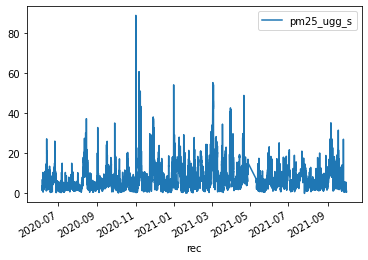

In [4]:
# Check the pm25 time series to make sure it doesn't include the hump
# at the start of 2021
#---------------------------------------------------------------------
sebbes_train_s15.reset_index().plot('rec','pm25_ugg_s')

## Do some feature engineering

In [4]:
# Apply feature generation functions to St Ebbes training
# ---------------------------------------------------------
tmp_list = []
for tag, dat in sebbes_train_s15.reset_index().groupby('tag'):
    tmpdf = no2_feature_gen(dat)
    tmpdf = rushhour(tmpdf)
    tmp_list.append(tmpdf)
sebbes_train_s15_1 = pd.concat(tmp_list)


## Subset to constrain to training features
Select only interesting features & subset / constrain the training sample population to specific time envelope.

In [5]:
# Create the training dataset
#-----------------------------
train_df = get_training_pm25([sebbes_train_s15_1], '2020-06-01','2021-09-01')
train_df.info()

Getting training features for sensors between: 2020-06-01 00:00:00+00:00 and 2021-09-01 00:00:00+00:00

Sensors in output :['scs-bgx-538']

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 30902 entries, ('scs-bgx-538', Timestamp('2020-06-05 00:45:00+0000', tz='UTC')) to ('scs-bgx-538', Timestamp('2021-08-31 23:45:00+0000', tz='UTC'))
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   val.mtf1             30902 non-null  float64
 1   val.mtf5             30902 non-null  float64
 2   val.mtf3             30902 non-null  float64
 3   val.mtf7             30902 non-null  float64
 4   val.sfr              30902 non-null  float64
 5   val.hmd              30902 non-null  float64
 6   val.tmp              30902 non-null  float64
 7   pc15_val.mtf1        30902 non-null  float64
 8   pc15_val.mtf5        30902 non-null  float64
 9   pc15_val.mtf3        30902 non-null  float64
 10  pc15_val.mtf7        309

## Organise training data for Sklearn

In [6]:
# Define the training dataset. In this 1st cut using the full St Ebbes timeseries Jun-Nov
# ------------------------------------------------------------------------------------------

# Set training & target variables
X = train_df.drop(
    columns=['pm25_ugg_s']
)  # remove target variable (i.e. no2) from training set.

y = train_df['pm25_ugg_s']  # define target variable (i.e. no2).

# Split into training & validation (test) datasets for both dependent & independent variables
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=7, test_size=0.4)

## Fit & evaluate an RFR model

In [8]:
# Calculate model performance using MAE finction
# ------------------------------------------------

# Initialise vars with range of nodes to test
mini = 10
maxi = 7000
step = 500

candidate_max_leaf_nodes = np.arange(mini, maxi, step).tolist()

# Loop using dict comprehension to find the ideal tree size from number of nodes tested.
# The following line calls the get_mae function above for
# every value of nodes defined in candiate_max_leaf_nodes.
scores = {
    leaf_size: get_mae(leaf_size, train_X, val_X, train_y, val_y)
    for leaf_size in candidate_max_leaf_nodes
}
best_tree_size = min(scores, key=scores.get)

## Present results of K-fold cross validation evaluation of model performance

In [9]:
# Print leaf results
# --------------------
print(f'The best leaf node size between {mini} and {maxi} is:')
print(best_tree_size)
display(scores)

The best leaf node size between 10 and 7000 is:
6510


{10: (2.818646962971751, 2.787997935998211, 2.823907807398117),
 510: (1.35638093277002, 1.0132776753766852, 1.4144639815954554),
 1010: (1.2187276882784692, 0.7471498689119422, 1.2966044140671338),
 1510: (1.1646216193640222, 0.6192548233080519, 1.2554652932912205),
 2010: (1.1404634756391134, 0.5471253608550827, 1.2392908337766122),
 2510: (1.1286603013988998, 0.5033921652207167, 1.231366391418937),
 3010: (1.1221495641218877, 0.47645872143522905, 1.2283357214497836),
 3510: (1.1190790613282176, 0.45906960429981153, 1.226724246561643),
 4010: (1.1170905230747805, 0.44778873129467606, 1.2257261770033807),
 4510: (1.11601605722521, 0.4403794747984458, 1.2253955077413565),
 5010: (1.115305947871425, 0.43538434693806144, 1.2252277556321358),
 5510: (1.1147672050543465, 0.43193238296944486, 1.2250776495284605),
 6010: (1.1145804769238299, 0.4296787198462776, 1.2250331474471767),
 6510: (1.1144071169052512, 0.4281674605334565, 1.2249990166418236)}

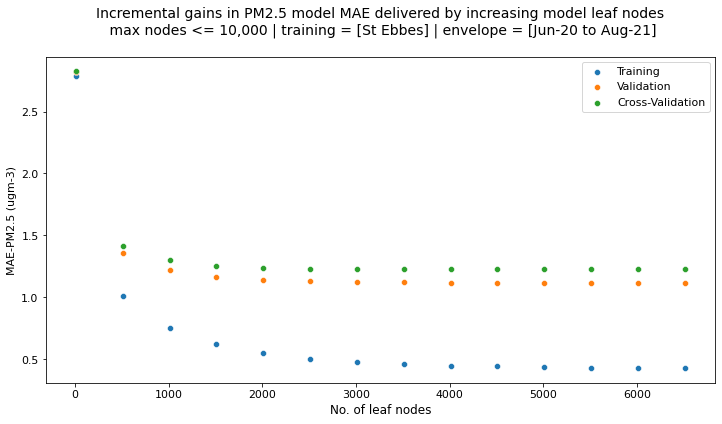

In [10]:
# Plot training & X validation results
# -------------------------------------
test = pd.DataFrame(scores)
plt.figure(figsize=(12, 6))

sns.scatterplot(x=test.columns, y=test.iloc[1], label='Training')
sns.scatterplot(x=test.columns, y=test.iloc[0], label='Validation')
sns.scatterplot(x=test.columns, y=test.iloc[2], label='Cross-Validation')

plt.ylabel('MAE-PM2.5 (ugm-3)', fontsize=11)
plt.xlabel('No. of leaf nodes', fontsize=12)
plt.title(
    'Incremental gains in PM2.5 model MAE delivered by increasing model leaf nodes\n \
max nodes <= 10,000 | training = [St Ebbes] | envelope = [Jun-20 to Aug-21]\n',
    fontsize=14,
)
plt.legend(fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Save figure if needed
# plt.savefig(pngs + 'training_results_pm10_mln10000_e100_536_ratified_sebbes_highs.png', dpi=300)
plt.grid(False)
plt.show()

## Model training
From the above fig we can choose 4,000 leaf nodes as the point beyond which gains are margins & set our maximum leaf nodes to this value.

In [11]:
# Redefine the model using best tree size & number of estimators
# --------------------------------------------------
model = RandomForestRegressor(
    max_leaf_nodes=4000, random_state=7, n_estimators=100, n_jobs=-1
)

# fit the model
model.fit(train_X, train_y)
model_prediction = model.predict(val_X)

## Validation results

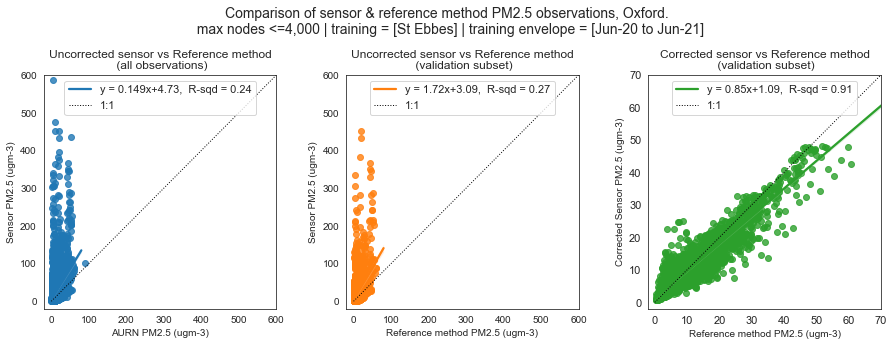

In [12]:
# Plotting a training story board
plot_training_story_board_pm25(train_df, 'Comparison of sensor & reference method PM2.5 observations, Oxford. \n \
max nodes <=4,000 | training = [St Ebbes] | training envelope = [Jun-20 to Jun-21]\n', False)

## Time series of model performance hold-out validation set

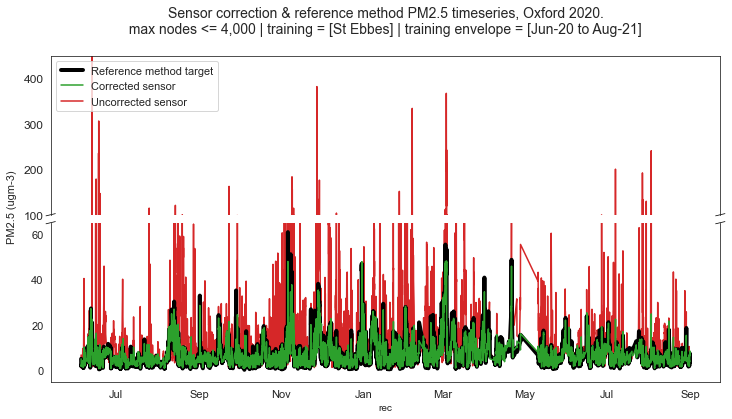

In [13]:
# Time series of validation hold out set
timeseries_plot_split_pm25(val_X=val_X, 
                      val_y=val_y,
                      title='Sensor correction & reference method PM2.5 timeseries, Oxford 2020.\n \
max nodes <= 4,000 | training = [St Ebbes] | training envelope = [Jun-20 to Aug-21] \n',
                      save_it=False
                     )

## Calculate feature/parameter importance

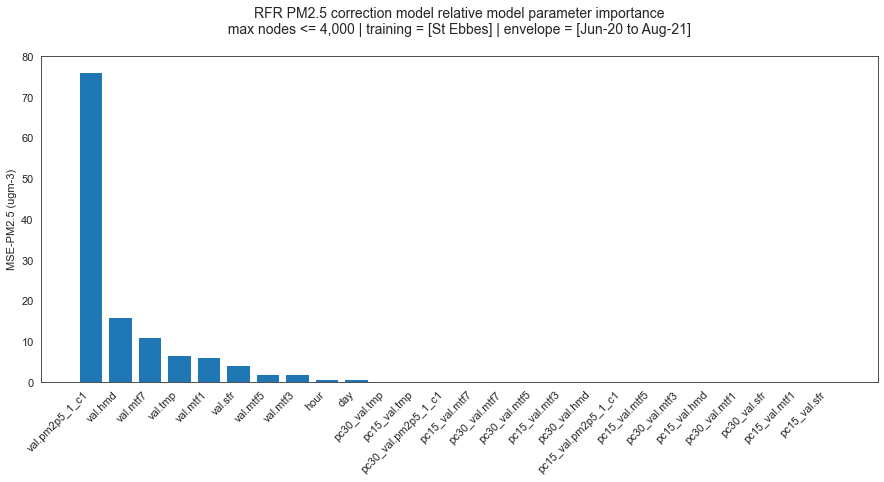

In [14]:
# Permutation importance is a method for determining how important a parameter is by sequentially
# shuffling model parameters and measuring the effect on model accuracy (MAE in this case)

# perform permutation importance
results = permutation_importance(
    model, train_X, train_y, scoring='neg_mean_squared_error'
)

# get importance
importance = results.importances_mean
importance = pd.DataFrame(importance, index=train_X.columns, columns=['MSE'])
importance = importance.sort_values(by='MSE', ascending=False)

sns.set_style('white', {'axes.grid': False})

fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(111)
plt.bar(importance.index, importance.MSE)
plt.ylabel('MSE-PM2.5 (ugm-3)', fontsize=11)
ax1.xaxis.set_tick_params(rotation=45)
plt.setp(ax1.xaxis.get_majorticklabels(), ha='right', fontsize=12)
plt.title(
    'RFR PM2.5 correction model relative model parameter importance\n \
max nodes <= 4,000 | training = [St Ebbes] | envelope = [Jun-20 to Aug-21] \n',
    fontsize=14,
)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Save figure if needed
# plt.savefig(pngs+'parameter_importance_pm10_mln6000_e100_536_sebbes_highs_ratified.png', dpi=300)
plt.show()

## Hold-out model validation set (val_y) vs reference

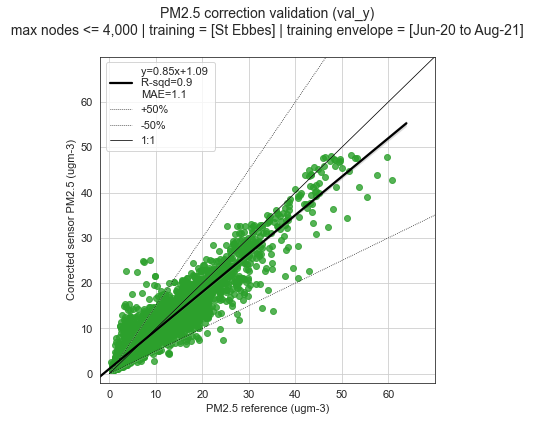

In [15]:
# Plot regression analysis of corrected verification sensor obs vs AURN
# -----------------------------------------------------------------------
sns.set_style('white', {'axes.grid': True})

one = [0, 20, 40, 60, 80, 110]
upper = [i * 1.50 for i in one]
lower = [i * 0.50 for i in one]

# Model prediction
model_prediction = model.predict(val_X)

slope, intercept, r_value, p_value, std_err = stats.linregress(val_y, model_prediction)
mae_veri = mean_absolute_error(val_y, model_prediction)

fig = plt.figure(1, figsize=(6, 6))
fig.add_subplot(111)

ax1.set_xlim(-2, 100)
ax1.set_ylim(-2, 100)


ax1 = sns.regplot(
    x=val_y,
    y=model_prediction,
    color='tab:green',
    line_kws={
        'label': 'y={0:.2f}x+{1:.2f} \nR-sqd={2:.1f} \nMAE={3:.1f}'.format(
            slope, intercept, r_value ** 2, mae_veri
        ),
        'color': 'k',
    },
    truncate=False
)
ax2 = sns.regplot(
    x=one,
    y=upper,
    color='k',
    line_kws={'label': '+50%', 'ls': ':', 'lw': 0.75},
    scatter_kws={'s': 0},
)

ax3 = sns.regplot(
    x=one,
    y=lower,
    color='k',
    line_kws={'label': '-50%', 'ls': ':', 'lw': 0.75},
    scatter_kws={'s': 0},
)

ax4 = sns.regplot(
    x=one,
    y=one,
    color='k',
    line_kws={'label': '1:1', 'ls': '-', 'lw': 0.75},
    scatter_kws={'s': 0},
)

ax1.set_title(
    'PM2.5 correction validation (val_y)\n \
max nodes <= 4,000 | training = [St Ebbes] | training envelope = [Jun-20 to Aug-21] \n',
    fontsize=14,
)
ax1.set_xlim(-2, 70)
ax1.set_ylim(-2, 70)
ax1.set_xticks(np.arange(0, 70, 10))
ax1.set_yticks(np.arange(0, 70, 10))
plt.legend(fontsize=11)
plt.ylabel('Corrected sensor PM2.5 (ugm-3)', fontsize=11)
plt.xlabel('PM2.5 reference (ugm-3)', fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Save figure if needed
plt.savefig('./oxaria/data/rf/gap_filling/536_method/ratified/oct_update/final_outputs/verification_regression_pm25_mln4000_e100_536_sebbes_highs_ratified.png',
            dpi=300)
plt.show()

## Save the model to disk

In [16]:
# Save the model to disk
#------------------------
filename = rf_home + 'RFR_model_pm25_mln4000_jun_aug_val_pm2p5_1_c2_S_xt.sav'
pickle.dump(model, open(filename, 'wb'))

In [8]:
# Read the saved model to avoid all the working above
# -----------------------------------------------------
model = pickle.load(
    open(rf_home + 'RFR_model_pm25_mln4000_jun_aug_val_pm2p5_1_c2_S_xt.sav', 'rb'))

## Export data for CEN uncertainty calculations

In [18]:
# Save the interesting variables to a csv for CEN expanded uncertainty calcs
# ----------------------------------------------------------------------------
import csv

outfile = list(
    zip(
        val_y.index.get_level_values(0),
        val_y.index.get_level_values(1).strftime('%m/%d/%Y %H:%M:%S'),
        val_y.values,
        model_prediction,
    )
)

with open(
    rf_home
    + 'values_for_cen_calc_RFR_model_pm25_mln4000_jun_aug_val_pm2p5_1_c2_S_xt.csv',
    'w',
) as out:
    csv_out = csv.writer(out)
    csv_out.writerow(['tag', 'datetime', 'pm25_ugg_s', 'val_pm2p5_1_c2_S_xt'])
    csv_out.writerows(outfile)

# Print the  MAE stats for model configured with extra uniform backround time slots
# -----------------------------------------------------------------------------------
mae_veri = mean_absolute_error(val_y, model_prediction)
mae_orig = mean_absolute_error(val_y, val_X['val.pm2p5_1_c1'])

print(
    'MAE in uncorrected verifiction data for Jun to Nov with uniform baseline: '
    + str(mae_orig)
)
print(
    'MAE in corrected verifiction data for Jun to Nov with uniform baseline: '
    + str(mae_veri)
)
print('% 0.1f' % mae_orig, '% 0.1f' % mae_veri)

MAE in uncorrected verifiction data for Jun to Nov with uniform baseline: 9.081788268866406
MAE in corrected verifiction data for Jun to Nov with uniform baseline: 1.1171001329074823
 9.1  1.1


# Model verification

In [19]:
# Generate out of sample / unseen verification set
#--------------------------------------------------
verification_df = get_training_pm25([sebbes_train_s15_1],'2021-09-01','2021-10-01')

Getting training features for sensors between: 2021-09-01 00:00:00+00:00 and 2021-10-01 00:00:00+00:00

Sensors in output :['scs-bgx-538']



Getting training features for sensors between: 2021-09-01 00:00:00+00:00 and 2021-10-01 00:00:00+00:00

Sensors in output :['scs-bgx-538']



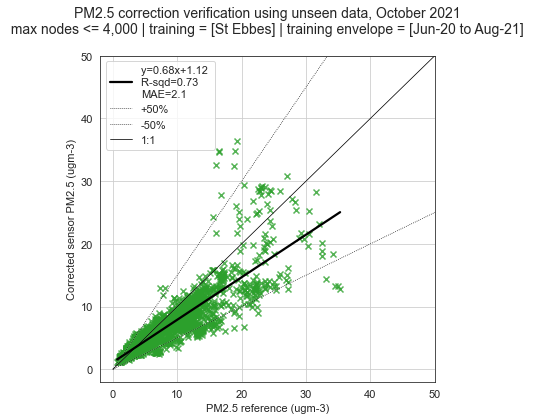

In [20]:
# Plotting the verification results using December 2020 data - split
# -------------------------------------------------------------------

# Generate out of sample / unseen verification set
verification_df = get_training_pm25([sebbes_train_s15_1],'2021-09-01','2021-10-01')
verification_df = verification_df.sort_index()

val_y = verification_df.loc[:, 'pm25_ugg_s']
val_X = verification_df.drop(
    columns=['pm25_ugg_s']
)

# Model prediction
model_prediction = model.predict(val_X)

sns.set_style('white', {'axes.grid': True})
myFmt = mdates.DateFormatter('%d-%b')

one = [0, 20, 40, 60, 80, 110]
upper = [i * 1.50 for i in one]
lower = [i * 0.50 for i in one]

# Model prediction
model_prediction = model.predict(val_X)

slope, intercept, r_value, p_value, std_err = stats.linregress(val_y, model_prediction)
mae_veri = mean_absolute_error(val_y, model_prediction)

fig = plt.figure(1, figsize=(6, 6))
fig.add_subplot(111)
ax1 = sns.regplot(
    x=val_y,
    y=model_prediction,
    color='tab:green',
    marker = 'x',
    ci=None,
    line_kws={
        'label': 'y={0:.2f}x+{1:.2f} \nR-sqd={2:.2f} \nMAE={3:.1f}'.format(
            slope, intercept, r_value ** 2, mae_veri
        ),
        'color': 'k',
    },
    #scatter_kws={'m': '+'},
)
ax2 = sns.regplot(
    x=one,
    y=upper,
    color='k',
    line_kws={'label': '+50%', 'ls': ':', 'lw': 0.75},
    scatter_kws={'s': 0},
)

ax3 = sns.regplot(
    x=one,
    y=lower,
    color='k',
    line_kws={'label': '-50%', 'ls': ':', 'lw': 0.75},
    scatter_kws={'s': 0},
)

ax4 = sns.regplot(
    x=one,
    y=one,
    color='k',
    line_kws={'label': '1:1', 'ls': '-', 'lw': 0.75},
    scatter_kws={'s': 0},
)

ax1.set_title(
    'PM2.5 correction verification using unseen data, October 2021\n \
max nodes <= 4,000 | training = [St Ebbes] | training envelope = [Jun-20 to Aug-21] \n',
    fontsize=14,
)
ax1.set_xlim(-2, 50)
ax1.set_ylim(-2, 50)
ax1.set_xticks(np.arange(0, 52, 10))
ax1.set_yticks(np.arange(0, 52, 10))
plt.legend(fontsize=11)
plt.ylabel('Corrected sensor PM2.5 (ugm-3)', fontsize=11)
plt.xlabel('PM2.5 reference (ugm-3)', fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.savefig('./oxaria/data/rf/gap_filling/536_method/ratified/oct_update/final_outputs/verification_regression_pm25_mln4000_e100_536_sebbes_highs_ratified_unseen.png',
            dpi=300)
plt.show()

## Time series verifying model performance on unseen data

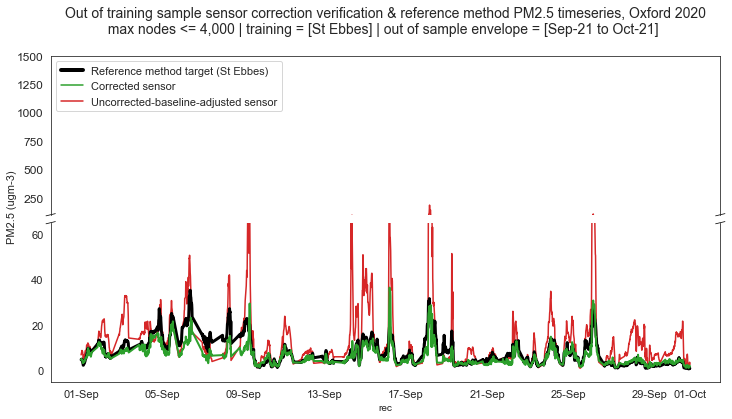

In [21]:
# Plotting the verification results using December 2020 data - split
# --------------------------------------------------------------------
verification_df.sort_index(inplace=True)
val_y = verification_df.loc[:, 'pm25_ugg_s']
val_X = verification_df.drop(
    columns=['pm25_ugg_s']
)

# Model prediction
model_prediction = model.predict(val_X)

sns.set_style('white', {'axes.grid': False})
myFmt = mdates.DateFormatter('%d-%b')

f, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 6))

sns.lineplot(
    x=val_y.index.get_level_values(1),
    y=val_y.values,
    label='Reference method target (St Ebbes)',
    color='k',
    lw=4,
    zorder=2,
    ax=ax,
)

sns.lineplot(
    x=val_X.index.get_level_values(1),
    y=model_prediction,
    label='Corrected sensor',
    color='tab:green',
    zorder=3,
    ax=ax,
)
sns.lineplot(
    x=val_X.index.get_level_values(1),
    y=val_X['val.pm2p5_1_c1'],
    label='Uncorrected-baseline-adjusted sensor',
    color='tab:red',
    zorder=1,
    ax=ax,
)
sns.lineplot(
    x=val_y.index.get_level_values(1), 
    y=val_y.values, 
    color='k', 
    lw=3, 
    zorder=4, 
    ax=ax2
)
sns.lineplot(
    x=val_X.index.get_level_values(1),
    y=model_prediction,
    color='tab:green',
    lw=2,
    zorder=5,
    ax=ax2,
)
sns.lineplot(
    x=val_X.index.get_level_values(1),
    y=val_X['val.pm2p5_1_c1'],
    color='tab:red',
    zorder=2,
    ax=ax2,
)

# zoom-in / limit the view to different portions of the data
ax.set_ylim(100, 1500)  # outliers only
ax2.set_ylim(-5, 65)  # most of the data

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('none')
ax2.yaxis.set_label_coords(-0.05, 1.1)
ax.yaxis.label.set_visible(False)

d = 0.007  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False, lw=0.75)
ax.plot((-d, +d), (-d, +d), **kwargs)  # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
ax2.xaxis.set_major_formatter(myFmt)
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# What's cool about this is that now if we vary the distance between
# ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
# the diagonal lines will move accordingly, and stay right at the tips
# of the spines they are 'breaking'

f.subplots_adjust(hspace=0.05)

plt.ylabel('PM2.5 (ugm-3)', fontsize=11)
ax.legend(loc='upper left', fontsize=11)
ax.set_title(
    'Out of training sample sensor correction verification & reference method PM2.5 timeseries, Oxford 2020\n \
max nodes <= 4,000 | training = [St Ebbes] | out of sample envelope = [Sep-21 to Oct-21]  \n',
    fontsize=14,
)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
# plt.savefig(pngs + 'verification_results_pm10_mln6000_e100_536_sebbes_highs_ratified_dec_split.png', dpi=300)
plt.show()

## Export data for CEN uncertainty calculations

In [22]:
# Save the interesting variables to a csv for CEN expanded uncertainty calcs
# ----------------------------------------------------------------------------
outfile = list(zip(val_X.index.get_level_values(0), val_X.index.get_level_values(1), val_y.values, model_prediction))

with open(
    rf_home + 'values_for_cen_calc_RFR_model_pm25_mln4000_jun_aug_val_pm2p5_1_c2_S_xt_unseen.csv', 'w') as out:
    csv_out = csv.writer(out)
    csv_out.writerow(['tag', 'rec', 'pm25_ugg_s', 'val.pm2p5_1_c2_S_xt'])
    csv_out.writerows(outfile)

mae_veri = mean_absolute_error(val_y.values, model_prediction)
mae_orig = mean_absolute_error(val_y.values, val_X['val.pm2p5_1_c1'])

print('MAE in uncorrected verifiction data for December: ' + str(mae_orig))
print('MAE in corrected verifiction data for December: ' + str(mae_veri))
print('% 0.1f' % mae_orig, '% 0.1f' % mae_veri)

MAE in uncorrected verifiction data for December: 6.902344
MAE in corrected verifiction data for December: 2.0826069110656915
 6.9  2.1


## Time series showing model performance across the full study period

Getting training features for sensors between: 2020-06-01 00:00:00+00:00 and 2021-10-01 00:00:00+00:00

Sensors in output :['scs-bgx-538']

 



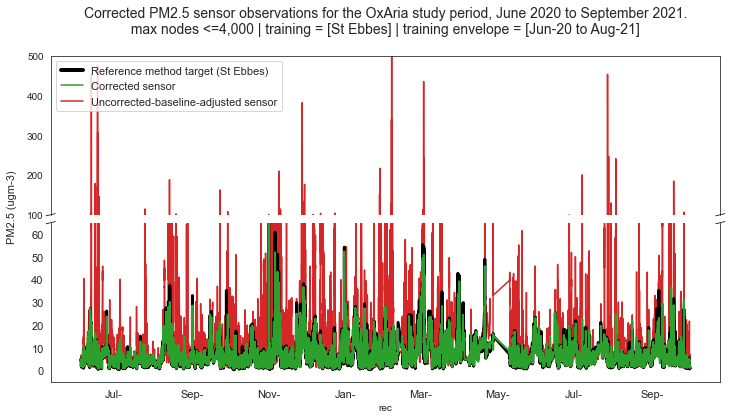

In [9]:
# Plotting the fullstudy results using December 2020 data - split
# --------------------------------------------------------------------
study_period_df = get_training_pm25([sebbes_train_s15_1],'2020-06-01','2021-10-01')
print(' \n')

study_period_df.sort_index(inplace=True)
val_y = study_period_df.loc[:, 'pm25_ugg_s']
val_X = study_period_df.drop(
    columns=['pm25_ugg_s']
)

# Model prediction
model_prediction = model.predict(val_X)

sns.set_style('white', {'axes.grid': False})
myFmt = mdates.DateFormatter('%b-')

f, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 6))

sns.lineplot(
    x=val_y.index.get_level_values(1),
    y=val_y.values,
    label='Reference method target (St Ebbes)',
    color='k',
    lw=4,
    zorder=2,
    ax=ax,
)

sns.lineplot(
    x=val_X.index.get_level_values(1),
    y=model_prediction,
    label='Corrected sensor',
    color='tab:green',
    zorder=3,
    ax=ax,
)
sns.lineplot(
    x=val_X.index.get_level_values(1),
    y=val_X['val.pm2p5_1_c1'],
    label='Uncorrected-baseline-adjusted sensor',
    color='tab:red',
    zorder=1,
    ax=ax,
)
sns.lineplot(
    x=val_y.index.get_level_values(1), 
    y=val_y.values, 
    color='k', 
    lw=3, 
    zorder=4, 
    ax=ax2
)
sns.lineplot(
    x=val_X.index.get_level_values(1),
    y=model_prediction,
    color='tab:green',
    lw=2,
    zorder=5,
    ax=ax2,
)
sns.lineplot(
    x=val_X.index.get_level_values(1),
    y=val_X['val.pm2p5_1_c1'],
    color='tab:red',
    zorder=2,
    ax=ax2,
)

# zoom-in / limit the view to different portions of the data
ax.set_ylim(100, 500)  # outliers only
ax2.set_ylim(-5, 65)  # most of the data

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('none')
ax2.yaxis.set_label_coords(-0.05, 1.1)
ax.yaxis.label.set_visible(False)

d = 0.007  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False, lw=0.75)
ax.plot((-d, +d), (-d, +d), **kwargs)  # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
ax2.xaxis.set_major_formatter(myFmt)
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# What's cool about this is that now if we vary the distance between
# ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
# the diagonal lines will move accordingly, and stay right at the tips
# of the spines they are 'breaking'

f.subplots_adjust(hspace=0.05)

plt.ylabel('PM2.5 (ugm-3)', fontsize=11)
ax.legend(loc='upper left', fontsize=11)
ax.set_title(
    'Corrected PM2.5 sensor observations for the OxAria study period, June 2020 to September 2021.\n \
max nodes <=4,000 | training = [St Ebbes] | training envelope = [Jun-20 to Aug-21] \n',
    fontsize=14,
)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
# plt.savefig(pngs + 'verification_results_pm10_mln6000_e100_536_sebbes_highs_ratified_dec_split.png', dpi=300)
plt.show()

## Regression plot of 15-minute averaged corrected sensor PM2.5 observations vs reference method

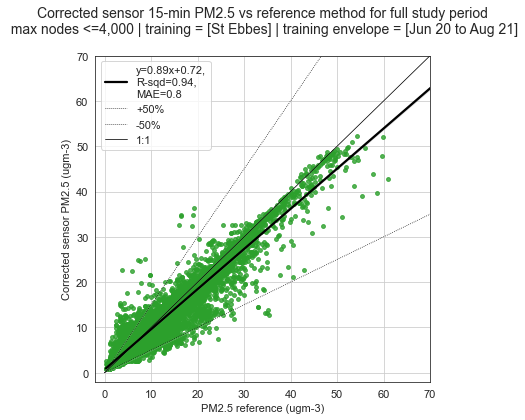

In [33]:
# Plot regression analysis of corrected verification sensor obs vs AURN
# -----------------------------------------------------------------------
study_period_df.sort_index(inplace=True)
val_y = study_period_df.loc[:, 'pm25_ugg_s']
val_X = study_period_df.drop(
    columns=['pm25_ugg_s']
)

# Model prediction
model_prediction = model.predict(val_X)

sns.set_style('white', {'axes.grid': True})

one = [0, 20, 40, 60, 80, 100]
upper = [i * 1.50 for i in one]
lower = [i * 0.50 for i in one]

slope, intercept, r_value, p_value, std_err = stats.linregress(
    val_y.values, model_prediction
)
mae_veri = mean_absolute_error(val_y.values, model_prediction)
# mae_orig = mean_absolute_error(val_y, val_X['val.pm10_1_c1'])

fig = plt.figure(1, figsize=(6, 6))
fig.add_subplot(111)
ax1 = sns.regplot(
    x=val_y.values,
    y=model_prediction,
    color='tab:green',
    line_kws={
        'label': 'y={0:.2f}x+{1:.2f},\nR-sqd={2:.2f},\nMAE={3:.1f}'.format(
            slope, intercept, r_value**2, mae_veri, mae_orig
        ),
        'color': 'k',
    },
    scatter_kws={'s': 15},
)
ax2 = sns.regplot(
    x=one,
    y=upper,
    color='k',
    line_kws={'label': '+50%', 'ls': ':', 'lw': 0.75},
    scatter_kws={'s': 0},
)

ax3 = sns.regplot(
    x=one,
    y=lower,
    color='k',
    line_kws={'label': '-50%', 'ls': ':', 'lw': 0.75},
    scatter_kws={'s': 0},
)

ax4 = sns.regplot(
    x=one,
    y=one,
    color='k',
    line_kws={'label': '1:1', 'ls': '-', 'lw': 0.75},
    scatter_kws={'s': 0},
)

ax1.set_title(
    'Corrected sensor 15-min PM2.5 vs reference method for full study period\n \
max nodes <=4,000 | training = [St Ebbes] | training envelope = [Jun 20 to Aug 21]\n',
    fontsize=14,
)
ax1.set_xlim(-2, 70)
ax1.set_ylim(-2, 70)
ax1.set_xticks(np.arange(0, 75, 10))
ax1.set_yticks(np.arange(0, 75, 10))
plt.legend(fontsize=11)
plt.ylabel('Corrected sensor PM2.5 (ugm-3)', fontsize=11)
plt.xlabel('PM2.5 reference (ugm-3)', fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Save figure if needed
# plt.savefig(pngs + 'verification_regression_pm10_mln6000_e100_536_sebbes_highs_ratified_combo.png',
#            dpi=300)
plt.show()

## Regression plot of 1-hour averaged corrected sensor PM2.5 observations vs reference method

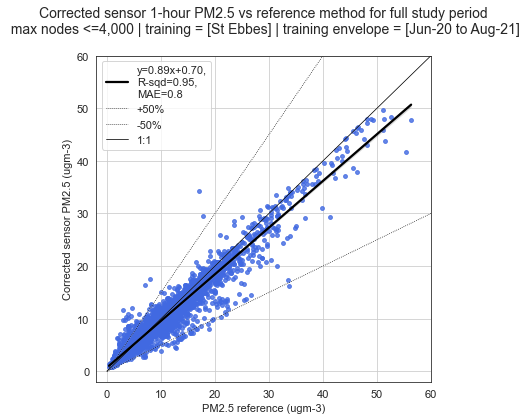

In [13]:
# Plot regression analysis of corrected verification sensor obs vs AURN
# -----------------------------------------------------------------------
sns.set_style('white', {'axes.grid': True})

one = [0, 20, 40, 60, 80, 100]
upper = [i * 1.50 for i in one]
lower = [i * 0.50 for i in one]

study_period_df.sort_index(inplace=True)
val_y = study_period_df.loc[:, 'pm25_ugg_s']
val_X = study_period_df.drop(
    columns=['pm25_ugg_s']
)

# Model prediction
model_prediction = model.predict(val_X)

dftmp0 = pd.concat(
    [val_y.reset_index(), pd.DataFrame(model_prediction, columns=['model_prediction'])],
    axis=1,
).set_index(['tag', 'rec'])

dftmp1 = dftmp0.groupby(
    [
        pd.Grouper(level='tag'),
        pd.Grouper(
            level='rec', freq='1H', label='right', convention='end', origin='epoch'
        ),
    ]
).mean()


slope, intercept, r_value, p_value, std_err = stats.linregress(
    dftmp1.iloc[:, 0].values, dftmp1.iloc[:, 1].values
)
mae_veri = mean_absolute_error(dftmp1.iloc[:, 0].values, dftmp1.iloc[:, 1].values)
# mae_orig = mean_absolute_error(val_y, val_X['val.pm10_1_c1'])

fig = plt.figure(1, figsize=(6, 6))
fig.add_subplot(111)
ax1 = sns.regplot(
    x=dftmp1.iloc[:, 0].values,
    y=dftmp1.iloc[:, 1].values,
    color='royalblue',
    marker='o',
    line_kws={
        'label': 'y={0:.2f}x+{1:.2f},\nR-sqd={2:.2f},\nMAE={3:.1f}'.format(
            slope, intercept, r_value**2, mae_veri
        ),
        'color': 'k',
    },
    scatter_kws={'s': 15},
)
ax2 = sns.regplot(
    x=one,
    y=upper,
    color='k',
    line_kws={'label': '+50%', 'ls': ':', 'lw': 0.75},
    scatter_kws={'s': 0},
)

ax3 = sns.regplot(
    x=one,
    y=lower,
    color='k',
    line_kws={'label': '-50%', 'ls': ':', 'lw': 0.75},
    scatter_kws={'s': 0},
)

ax4 = sns.regplot(
    x=one,
    y=one,
    color='k',
    line_kws={'label': '1:1', 'ls': '-', 'lw': 0.75},
    scatter_kws={'s': 0},
)

ax1.set_title(
    'Corrected sensor 1-hour PM2.5 vs reference method for full study period\n \
max nodes <=4,000 | training = [St Ebbes] | training envelope = [Jun-20 to Aug-21]\n',
    fontsize=14,
)
ax1.set_xlim(-2, 60)
ax1.set_ylim(-2, 60)
ax1.set_xticks(np.arange(0, 65, 10))
ax1.set_yticks(np.arange(0, 65, 10))
plt.legend(fontsize=11)
plt.ylabel('Corrected sensor PM2.5 (ugm-3)', fontsize=11)
plt.xlabel('PM2.5 reference (ugm-3)', fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Save figre if needed
plt.savefig(pngs + 'verification_regression_pm25_mln4000_e100_536_sebbes_ratified_combo_1hr.png',
            dpi=300)
plt.show()

# Save the interesting variables to a csv for CEN expanded uncertainty calcs
# ----------------------------------------------------------------------------
outfile = list(
    zip(
        dftmp1.index.get_level_values(0),
        dftmp1.index.get_level_values(1).strftime('%m/%d/%Y %H:%M:%S'),
        dftmp1['pm25_ugg_s'].values,
        dftmp1['model_prediction'].values
    )
)

with open(
    rf_home
    + 'values_for_cen_calc_RFR_model_pm25_mln4000_jun_aug_val_pm2p5_1_c2_S_xt_1hr.csv',
    'w',
) as out:
    csv_out = csv.writer(out)
    csv_out.writerow(['tag', 'datetime', 'pm25_ugg_s', 'val_pm2p5_1_c2_S_xt'])
    csv_out.writerows(outfile)

## Scatter plots of corrected PM2.5 vs reference concentration colour scaled by magnitude of selected interferents

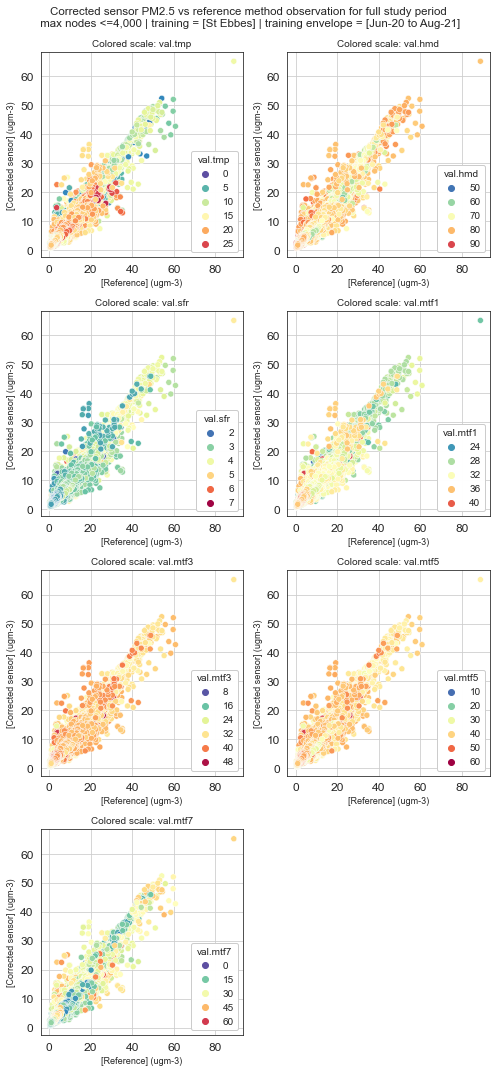

In [28]:
# Scatter plots of corrected vs reference & feature importance for the study period  
study_period_df.sort_index(inplace=True)
val_y = study_period_df.loc[:, 'pm25_ugg_s']
val_X = study_period_df.drop(
    columns=['pm25_ugg_s']
)
model_prediction = model.predict(val_X)

plot_list = ['val.tmp', 'val.hmd', 'val.sfr', 'val.mtf1', 'val.mtf3', 'val.mtf5', 'val.mtf7']

cmap_r = color_map = plt.cm.get_cmap('Spectral').reversed()

fig, axes = plt.subplots(nrows=4, ncols=2, sharex=False, sharey=False, figsize=(7,15))
axes_list = [item for sublist in axes for item in sublist] 

fig.suptitle('Corrected sensor PM2.5 vs reference method observation for full study period\n \
max nodes <=4,000 | training = [St Ebbes] | training envelope = [Jun-20 to Aug-21]', fontsize=11.5, y=0.99)

for i in plot_list:
    ax = axes_list.pop(0)
    sns.scatterplot(x=val_y, y=model_prediction, hue=val_X[i], ax=ax, palette=cmap_r)
    ax.set_title(f'Colored scale: {i}', fontsize=10)
    ax.set_ylabel('[Corrected sensor] (ugm-3)', fontsize=9)
    ax.set_xlabel('[Reference] (ugm-3)', fontsize=9)
    ax.legend(frameon=True, framealpha=0.99, loc='lower right', title=i)
    ax.grid(True)
fig.delaxes(axes_list[-1])
plt.tight_layout()
   
plt.show()

